In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import joblib
import pickle

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.layers import BatchNormalization
from keras.layers import Input, Dense, Conv1D, Conv1DTranspose, Dropout, MaxPooling1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/ECG_Data/ptbdb_normal.csv", header = None, index_col = False)
df1 = pd.read_csv("/content/gdrive/MyDrive/ECG_Data/ptbdb_abnormal.csv", header = None, index_col = False)
merged_df = pd.merge(df, df1, how='outer')
raw_data = merged_df.values
merged_df.head()

In [ ]:
merged_df.shape
np.save('/content/gdrive/MyDrive/ECG_Data/ptbdb_merged', merged_df)

NameError: ignored

In [ ]:
MITdf = pd.read_csv("/content/gdrive/MyDrive/ECG_Data/mitbih_train.csv", header = None, index_col= False)
raw_data = MITdf.values
MITdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [ ]:
load_df = np.load('/content/gdrive/MyDrive/ECG_Data/ptbdb_merged.npy')
raw_data = pd.DataFrame(load_df).values

In [ ]:
labels = raw_data[:,-1]
anomal_labels = np.where(labels == 2.0, 1.0, labels)
anomal_labels = np.where(labels == 3.0, 1.0, labels)
anomal_labels = np.where(labels == 4.0, 1.0, labels)
print(anomal_labels)
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, anomal_labels, test_size = 0.2, random_state = 21
)


[0. 0. 0. ... 1. 1. 1.]


In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

#normal_train_data = train_data[train_labels]
#normal_test_data = test_data[test_labels]

#anomalous_train_data = train_data[~train_labels]
#anomalous_test_data = test_data[~test_labels]

In [ ]:
print(normal_train_data.shape)
print(anomalous_train_data.shape)

(57989, 187)
(12054, 187)


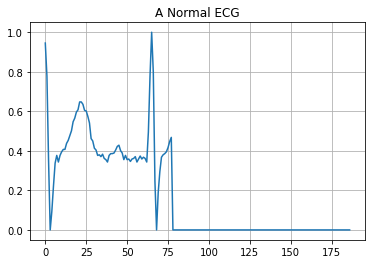

In [ ]:
plt.grid()
plt.plot(np.arange(187), normal_train_data[0])
# plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()
# for i in range(15):
#   plt.plot(np.arange(140), normal_train_data[i])
#   plt.title("A Normal ECG")
#   plt.show()

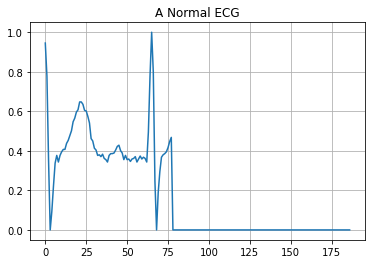

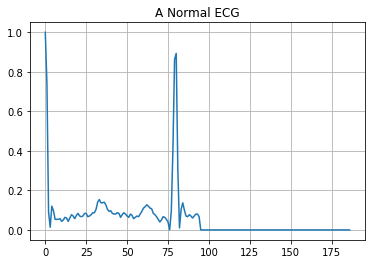

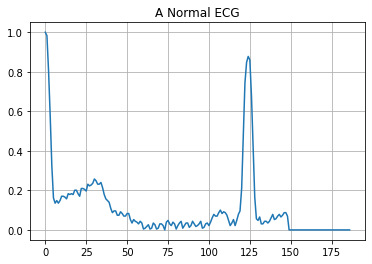

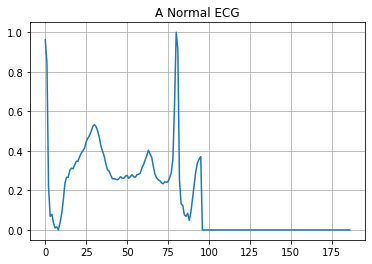

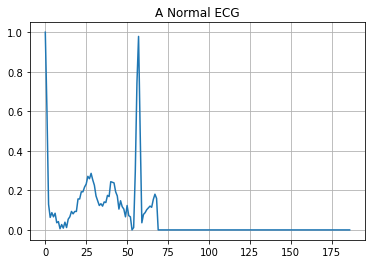

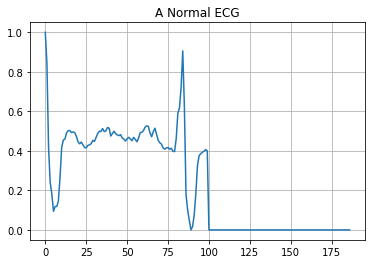

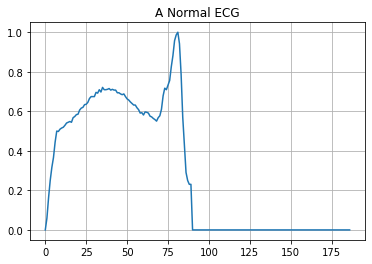

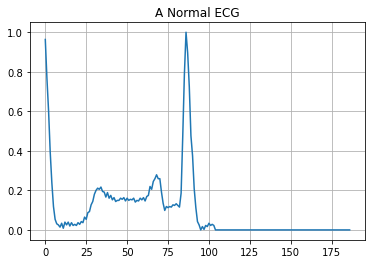

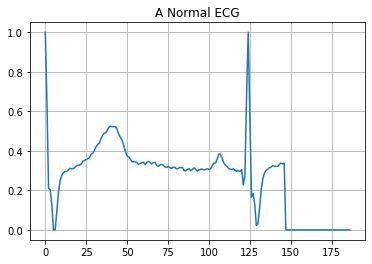

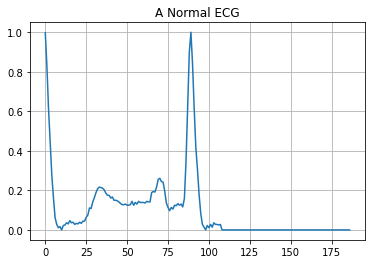

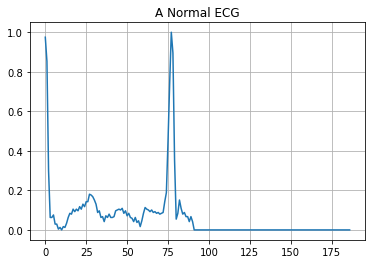

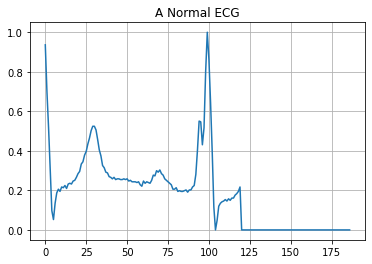

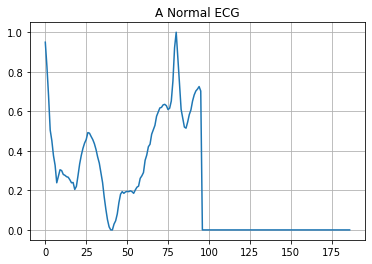

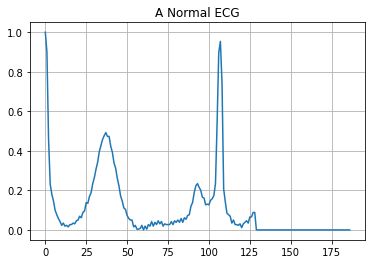

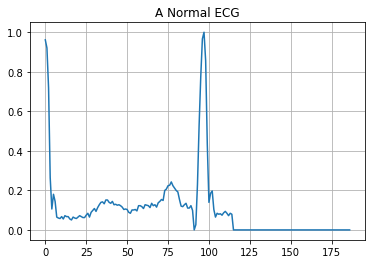

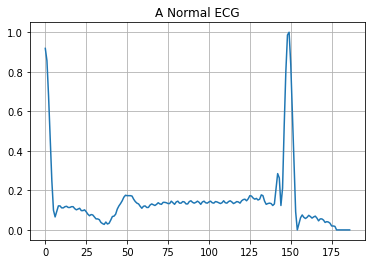

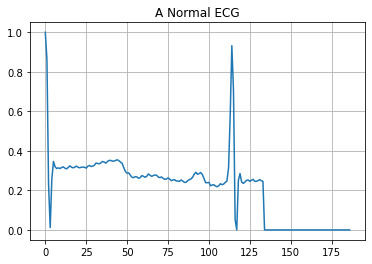

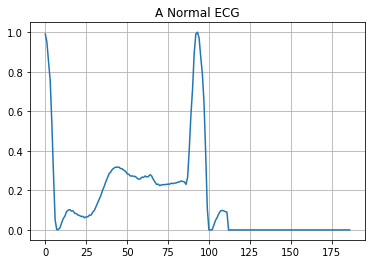

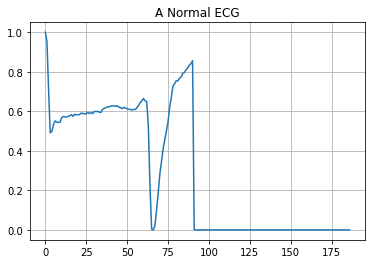

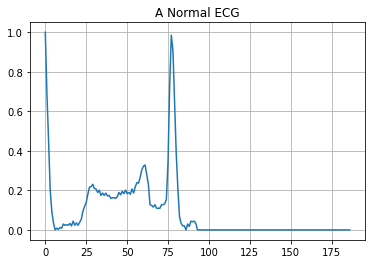

In [ ]:
for i in range(20):
  plt.grid()
  plt.plot(np.arange(187), normal_train_data[i])
  plt.title("A Normal ECG")
  plt.show()

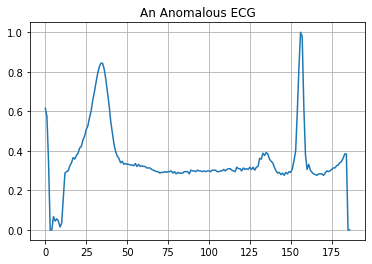

In [ ]:
plt.grid()
plt.plot(np.arange(187), anomalous_train_data[0])
# plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [ ]:
class AnomalyDetector_Conv(Model):
  def __init__(self):
    super(AnomalyDetector_Conv, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(187, 1)),
      Conv1D(filters=64, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1D(filters=32, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1D(filters=16, kernel_size=7, padding='same', strides=2, activation="relu")])

    self.decoder = tf.keras.Sequential([
      Conv1DTranspose(filters=16, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=32, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=64, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1D(filters=64, kernel_size=6, strides=1, activation="relu"),
      Conv1DTranspose(filters=1, kernel_size=7, padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_conv = AnomalyDetector_Conv()

In [ ]:
autoencoder_conv.compile(optimizer='adam', loss='mae')

In [ ]:
history_conv = autoencoder_conv.fit(normal_train_data, normal_train_data, 
                                    epochs=10, 
                                    batch_size=512,
                                    validation_data=(test_data, test_data),
                                    shuffle=True)

Epoch 1/10
114/114 [==============================] - 85s 737ms/step - loss: 0.0473 - val_loss: 0.0227
Epoch 2/10
114/114 [==============================] - 84s 738ms/step - loss: 0.0143 - val_loss: 0.0109
Epoch 3/10
114/114 [==============================] - 84s 737ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 4/10
114/114 [==============================] - 84s 735ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 5/10
114/114 [==============================] - 84s 735ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 6/10
114/114 [==============================] - 84s 736ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 7/10
114/114 [==============================] - 83s 731ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 8/10
114/114 [==============================] - 84s 735ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 9/10
114/114 [==============================] - 84s 736ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 10/10
114/114 [==============================] - 84s 737ms/step - l

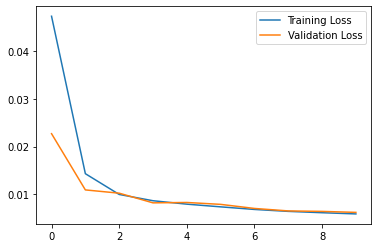

In [ ]:
plt.plot(history_conv.history["loss"], label="Training Loss")
plt.plot(history_conv.history["val_loss"], label="Validation Loss")
plt.legend()

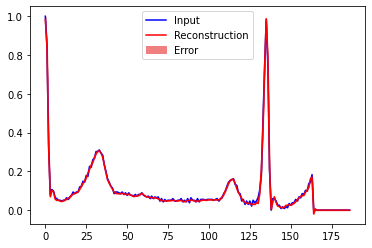

In [ ]:
encoded_imgs = autoencoder_conv.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder_conv.decoder(encoded_imgs).numpy()
decoded_imgs = np.squeeze(decoded_imgs)
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(187), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

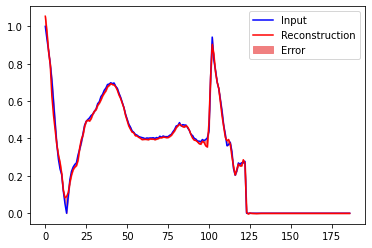

In [ ]:
encoded_imgs = autoencoder_conv.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder_conv.decoder(encoded_imgs).numpy()
decoded_imgs = np.squeeze(decoded_imgs)

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(187), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

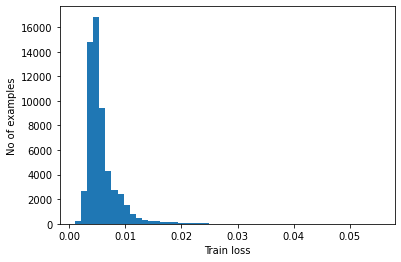

In [ ]:
reconstructions_conv = autoencoder_conv.predict(normal_train_data)
reconstructions_conv = np.squeeze(reconstructions_conv)
train_loss = tf.keras.losses.mae(reconstructions_conv, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.008694596


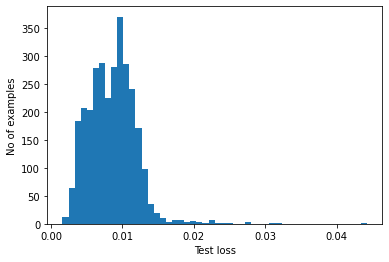

In [ ]:
reconstructions_conv = autoencoder_conv.predict(anomalous_test_data)
reconstructions_conv = np.squeeze(reconstructions_conv)
test_loss = tf.keras.losses.mae(reconstructions_conv, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict_conv(model, data, threshold):
  reconstructions = model(data)
  reconstructions = np.squeeze(reconstructions)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
pred_conv = predict_conv(autoencoder_conv, test_data, threshold)
print_stats(pred_conv, ~test_labels)

Accuracy = 0.8191422534406945
Precision = 0.8937295566845292
Recall = 0.8867559729319154


In [ ]:
class AnomalyDetector_Conv_v2(Model):
  def __init__(self):
    super(AnomalyDetector_Conv_v2, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(187, 1)),
      Conv1D(filters=32, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1D(filters=16, kernel_size=7, padding='same', strides=2, activation="relu")])

    self.decoder = tf.keras.Sequential([
      Conv1DTranspose(filters=16, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=32, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=1, kernel_size=7, padding='same'),
      Conv1D(filters=1, kernel_size=2, strides=1, activation="relu")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_conv_v2 = AnomalyDetector_Conv_v2()

In [ ]:
autoencoder_conv_v2.compile(optimizer='adam', loss='mae')

In [ ]:
history_conv_v2 = autoencoder_conv_v2.fit(normal_train_data, normal_train_data, 
                                          epochs=10, 
                                          batch_size=512,
                                          validation_data=(test_data, test_data),
                                          shuffle=True)

Epoch 1/10
114/114 [==============================] - 24s 208ms/step - loss: 0.0463 - val_loss: 0.0153
Epoch 2/10
114/114 [==============================] - 21s 188ms/step - loss: 0.0104 - val_loss: 0.0080
Epoch 3/10
114/114 [==============================] - 21s 188ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 4/10
114/114 [==============================] - 20s 180ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 5/10
114/114 [==============================] - 20s 180ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 6/10
114/114 [==============================] - 20s 179ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 7/10
114/114 [==============================] - 21s 181ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 8/10
114/114 [==============================] - 21s 181ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 9/10
114/114 [==============================] - 21s 182ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 10/10
114/114 [==============================] - 21s 181ms/step - l

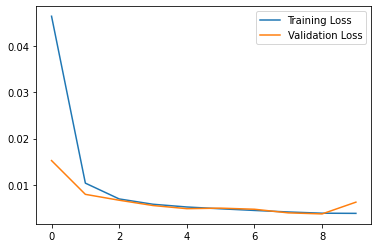

In [ ]:
plt.plot(history_conv_v2.history["loss"], label="Training Loss")
plt.plot(history_conv_v2.history["val_loss"], label="Validation Loss")
plt.legend()

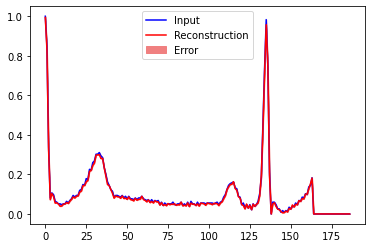

In [ ]:
encoded_imgs = autoencoder_conv_v2.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder_conv_v2.decoder(encoded_imgs).numpy()
decoded_imgs = np.squeeze(decoded_imgs)
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(187), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

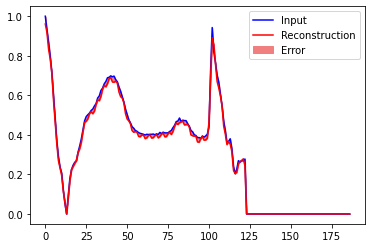

In [ ]:
encoded_imgs = autoencoder_conv_v2.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder_conv_v2.decoder(encoded_imgs).numpy()
decoded_imgs = np.squeeze(decoded_imgs)

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(187), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

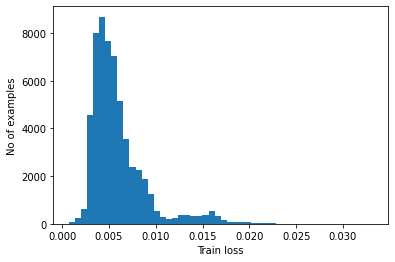

In [ ]:
reconstructions_conv_v2 = autoencoder_conv_v2.predict(normal_train_data)
reconstructions_conv_v2 = np.squeeze(reconstructions_conv_v2)
train_loss = tf.keras.losses.mae(reconstructions_conv_v2, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.008991467


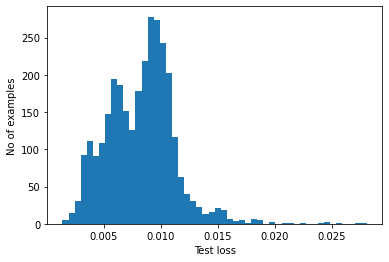

In [ ]:
reconstructions_conv_v2 = autoencoder_conv_v2.predict(anomalous_test_data)
reconstructions_conv_v2 = np.squeeze(reconstructions_conv_v2)
test_loss = tf.keras.losses.mae(reconstructions_conv_v2, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
pred_conv_v2 = predict_conv(autoencoder_conv_v2, test_data, threshold)
print_stats(pred_conv_v2, ~test_labels)

Accuracy = 0.8176574724458912
Precision = 0.8829116070822876
Recall = 0.8987018367628781


In [ ]:
fpr, tpr, thresholds = roc_curve(~test_labels, pred_conv_v2, pos_label=1)

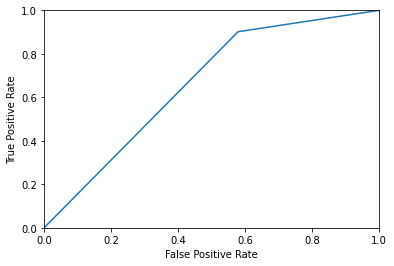

In [ ]:
def plot_roc_curve(fpr, tpr):
  plt.plot(fpr, tpr)
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()

plot_roc_curve(fpr, tpr)

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      Dense(32, activation="relu"),
      Dense(16, activation="relu"),
      Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      Dense(16, activation="relu"),
      Dense(32, activation="relu"),
      Dense(187, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
114/114 [==============================] - 1s 8ms/step - loss: 0.2049 - val_loss: 0.1406
Epoch 2/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0961 - val_loss: 0.0730
Epoch 3/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0630 - val_loss: 0.0643
Epoch 4/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0571 - val_loss: 0.0604
Epoch 5/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0548 - val_loss: 0.0584
Epoch 6/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0533 - val_loss: 0.0569
Epoch 7/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0518 - val_loss: 0.0550
Epoch 8/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0502 - val_loss: 0.0538
Epoch 9/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0490 - val_loss: 0.0528
Epoch 10/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0482 - val_loss: 0.0521

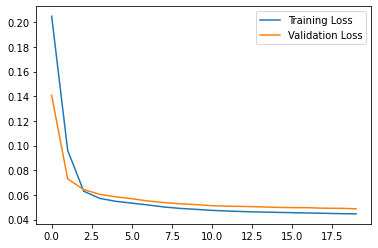

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

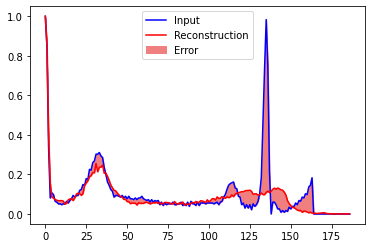

In [ ]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(187), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

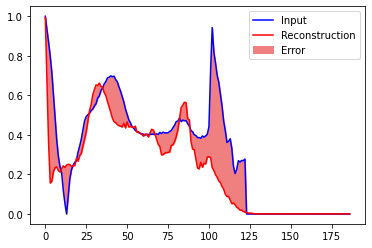

In [ ]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(187), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

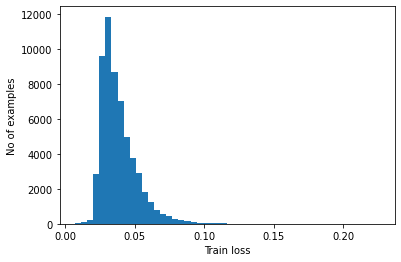

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.052140784


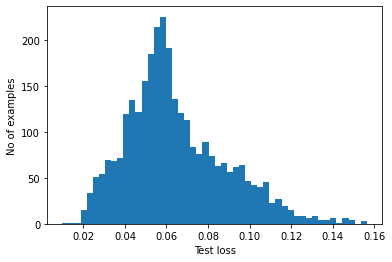

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, ~test_labels)

Accuracy = 0.8354177374221917
Precision = 0.9291845493562232
Recall = 0.8670763706670349


In [ ]:
model = tf.keras.Sequential(
    [
     Input(shape=(187, 1)),
     Conv1D(filters=32, kernel_size=7, padding='same', strides=2, activation="relu"),
     Conv1D(filters=16, kernel_size=7, padding='same', strides=2, activation="relu"),
     Conv1DTranspose(filters=16, kernel_size=7, padding='same', strides=2, activation="relu"),
     Conv1DTranspose(filters=32, kernel_size=7, padding='same', strides=2, activation="relu"),
     Conv1DTranspose(filters=1, kernel_size=7, padding='same'),
     Conv1D(filters=1, kernel_size=2, strides=1, activation="relu"),
    ]
)
model.compile(optimizer='adam', loss='mae')
model.summary()